In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [45]:
def loaddata(filename): 
    #trainSet = []
    #testSet = []
    dataset=pd.read_csv(filename)
    dataset.drop(columns="pred")
    #dataset.drop(columns="class")
    dataset.drop(columns="spectrometric_redshift")

    print(len(dataset))
    return dataset
    
#     lines = csv.reader(open(file1 , 'r')) 
#     dataset = list(lines)
#     for i in range(len(dataset)):
#         for j in range(len(dataset[i])):
#             dataset[i][j] = float(dataset[i][j])
#         testSet.append ( dataset[i] )
#     return trainSet , testSet

In [46]:
def cross_validation_split(dataset , n_folds): 
    dataset_split = list()
    dataset_copy = dataset.values.tolist()
    fold_size = int(len(dataset) / n_folds)
    for i in range(n_folds): 
        fold = list()
        while len(fold) < fold_size:
            index = random.randrange(len(dataset_copy)) 
            fold.append(dataset_copy.pop(index))
        dataset_split.append(fold) 

    print(len(dataset_split))
    #print(dataset_split)
    return dataset_split

58 591
296


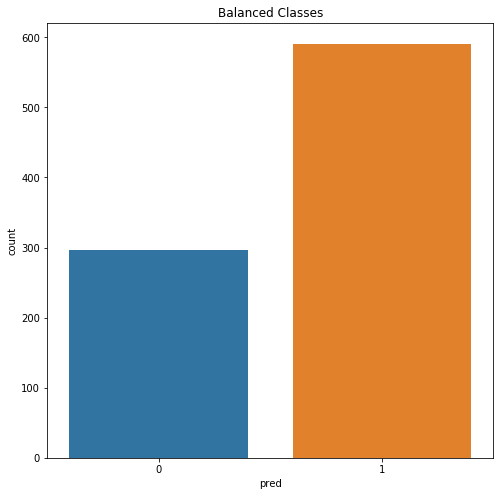

In [50]:
def upsampling():
    df=pd.read_csv('catalog1/cat1.csv')
    c0 = 0
    c1 = 0
    for i in df['pred']:
        if(i==0):
            c0+=1
        else:
            c1+=1


    print(c0,c1)

    resample_size = c1//2+1
    print(resample_size)


    # Shuffle the Dataset.
    shuffled_df = df.sample(frac=1,random_state=4)
    # print(len(shuffled_df))


    quaser = shuffled_df.loc[shuffled_df['pred'] == 1]
    star = shuffled_df.loc[shuffled_df['pred'] == 0].sample(n=resample_size,random_state=42, replace=True)

    # Concatenate both dataframes again
    normalized_df = pd.concat([star, quaser])

    #plot the dataset after the undersampling
    plt.figure(figsize=(8, 8))
    sns.countplot('pred', data=normalized_df)
    plt.title('Balanced Classes')
    plt.show()
    return normalized_df

ndf=upsampling()


In [51]:
ndf.head()

,Unnamed: 0,galex_objid,sdss_objid,u,g,r,i,z,extinction_u,extinction_g,...,r-i,r-z,i-z,fuv-nuv,fuv-u,fuv-g,fuv-r,fuv-i,fuv-z,pred
595,595,3.061500e+18,1.237668e+18,22.511520,21.195988,19.865002,18.973518,18.316504,0.107390,0.083677,...,0.891483,1.548498,0.657015,-1.170900,-0.977488,-2.293020,-3.624006,-4.515490,-5.172504,0
264,264,6.378727e+18,1.237668e+18,20.221161,20.016415,20.369156,20.702093,20.916876,0.063656,0.049601,...,-0.332937,-0.547720,-0.214783,0.392256,0.792728,0.587982,0.940723,1.273661,1.488443,0
129,129,6.374821e+18,1.237667e+18,19.805792,19.761148,20.141541,20.368341,20.823620,0.080151,0.062453,...,-0.226801,-0.682079,-0.455278,-0.179464,0.359043,0.314400,0.694792,0.921593,1.376871,0
390,390,6.378727e+18,1.237668e+18,20.531384,20.145739,20.355513,20.620770,20.867689,0.078877,0.061461,...,-0.265257,-0.512177,-0.246920,-0.240528,-0.306337,-0.691982,-0.482208,-0.216951,0.029968,0
450,450,6.378551e+18,1.237668e+18,20.388424,19.976339,20.265482,20.491510,20.669323,0.072227,0.056279,...,-0.226028,-0.403841,-0.177813,-0.551939,-0.164793,-0.576878,-0.287735,-0.061707,0.116106,0


In [52]:
import math
def entropy_func(c, n):
    """
    The math formula
    """
    return -(c*1.0/n)*math.log(c*1.0/n, 2)

def entropy_cal(c1, c2):
    """
    Returns entropy of a group of data
    c1: count of one class
    c2: count of another class
    """
    if c1== 0 or c2 == 0:  # when there is only one class in the group, entropy is 0
        return 0
    return entropy_func(c1, c1+c2) + entropy_func(c2, c1+c2)

# get the entropy of one big circle showing above
def entropy_of_one_division(division): 
    """
    Returns entropy of a divided group of data
    Data may have multiple classes
    """
    s = 0
    n = len(division)
    classes = set(division)
    for c in classes:   # for each class, get entropy
        n_c = sum(division==c)
        e = n_c*1.0/n * entropy_cal(sum(division==c), sum(division!=c)) # weighted avg
        s += e
    return s, n

# The whole entropy of two big circles combined
def get_entropy(y_predict, y_real):
    """
    Returns entropy of a split
    y_predict is the split decision, True/Fasle, and y_true can be multi class
    """
    if len(y_predict) != len(y_real):
        print('They have to be the same length')
        return None
    n = len(y_real)
    s_true, n_true = entropy_of_one_division(y_real[y_predict]) # left hand side entropy
    s_false, n_false = entropy_of_one_division(y_real[~y_predict]) # right hand side entropy
    s = n_true*1.0/n * s_true + n_false*1.0/n * s_false # overall entropy, again weighted average
    return s

In [57]:
class DecisionTreeClassifier(object):
    def __init__(self, max_depth):
        self.depth = 0
        self.max_depth = max_depth
    def find_best_split(self, col, y):
        """
        col: the column we split on
        y: target var
        """
        
        min_entropy = 10    
        n = len(y)
        for value in set(col):  # iterating through each value in the column
            y_predict = col < value  # separate y into 2 groups
            my_entropy = get_entropy(y_predict, y)  # get entropy of this split
            if my_entropy <= min_entropy:  # check if it's the best one so far
                min_entropy = my_entropy
                cutoff = value
        return min_entropy, cutoff

    def find_best_split_of_all(self, x, y):
        """
        Find the best split from all features
        returns: the column to split on, the cutoff value, and the actual entropy
        """
        col = None
        min_entropy = 1
        cutoff = None
        for i, c in enumerate(x):  # iterating through each feature
            entropy, cur_cutoff = self.find_best_split(x[c], y)  # find the best split of that feature
            if entropy == 0:    # find the first perfect cutoff. Stop Iterating
                return i, cur_cutoff, entropy
            elif entropy <= min_entropy:  # check if it's best so far
                min_entropy = entropy
                col = i
                cutoff = cur_cutoff
        return col, cutoff, min_entropy



    def fit(self, x, y, par_node={}, depth=0):
        """
        x: Feature set
        y: target variable
        par_node: will be the tree generated for this x and y. 
        depth: the depth of the current layer
        """
        if par_node is None:   # base case 1: tree stops at previous level
            return None
        elif len(y) == 0:   # base case 2: no data in this group
            return None
        elif self.all_same(y):   # base case 3: all y is the same in this group
            return {'val':y[0]}
        elif depth >= self.max_depth:   # base case 4: max depth reached 
            return None
        else:   # Recursively generate trees! 
            # find one split given an information gain 
            col, cutoff, entropy = self.find_best_split_of_all(x, y)   
            y_left = y[[x.iloc[:, col] < cutoff]  # left hand side data
            y_right = y[x.iloc[:, col] >= cutoff]  # right hand side data
            par_node = {'col': df.columns, 'index_col':col,
                      'cutoff':cutoff,
                    'val': np.round(np.mean(y))}  # save the information 
            # generate tree for the left hand side data
            par_node['left'] = self.fit(x[x[:, col] < cutoff], y_left, {}, depth+1)   
            # right hand side trees
            par_node['right'] = self.fit(x[x[:, col] >= cutoff], y_right, {}, depth+1)  
            self.depth += 1   # increase the depth since we call fit once
            self.trees = par_node  
            return par_node
        
    def all_same(self, items):
            return all(x == items[0] for x in items)

In [54]:
import pandas as pd
df=pd.read_csv('project/dataset/catalog1/cat1.csv')
#df.head()
#df.columns
df=df.drop(['Unnamed: 0', 'spectrometric_redshift','pred'],axis=1)
#df.head()
#df.head()
target=df['class']
target
df=df.drop(['class'],axis=1)


In [56]:
clf = DecisionTreeClassifier(max_depth=7)
m = clf.fit(df, target)

# import pprint
# pprint(m)

TypeError: unhashable type: 'slice'

In [ ]:
print(m)

In [58]:
##using sklearn

In [67]:
import numpy as np 
import pandas as pd 
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

df_new=pd.read_csv('catalog2/cat2.csv')
df_new=df_new.drop(['Unnamed: 0', 'spectrometric_redshift','pred'],axis=1)

Y=df_new['class']
X=df_new.drop(['class'],axis=1)
  

# Spliting the dataset into train and test 
X_train, X_test, y_train, y_test = train_test_split(  
X, Y, test_size = 0.3, random_state = 100) 

      
# Function to perform training with giniIndex. 
def train_using_gini(X_train, X_test, y_train): 
  
    # Creating the classifier object 
    clf_gini = DecisionTreeClassifier(criterion = "gini", random_state = 100,max_depth=3, min_samples_leaf=5) 
  
    # Performing training 
    clf_gini.fit(X_train, y_train) 
    return clf_gini 
      
# Function to perform training with entropy. 
def tarin_using_entropy(X_train, X_test, y_train): 
  
    # Decision tree with entropy 
    clf_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 100,max_depth = 3, min_samples_leaf = 5) 
  
    # Performing training 
    clf_entropy.fit(X_train, y_train) 
    return clf_entropy 
  
  
# Function to make predictions 
def prediction(X_test, clf_object): 
  
    # Predicton on test with giniIndex 
    y_pred = clf_object.predict(X_test) 
    print("Predicted values:") 
    print(y_pred) 
    return y_pred 
      
# Function to calculate accuracy 
def cal_accuracy(y_test, y_pred): 
      
    print("Confusion Matrix: ", 
        confusion_matrix(y_test, y_pred)) 
      
    print ("Accuracy : ", 
    accuracy_score(y_test,y_pred)*100) 
      
    print("Report : ", 
    classification_report(y_test, y_pred)) 
  

      
    # Building Phase 
clf_gini = train_using_gini(X_train, X_test, y_train) 
clf_entropy = tarin_using_entropy(X_train, X_test, y_train) 
      
    # Operational Phase 
print("Results Using Gini Index:") 
      
    # Prediction using gini 
y_pred_gini = prediction(X_test, clf_gini) 
cal_accuracy(y_test, y_pred_gini) 
      
print("Results Using Entropy:") 
    # Prediction using entropy 
y_pred_entropy = prediction(X_test, clf_entropy) 
cal_accuracy(y_test, y_pred_entropy) 

Results Using Gini Index:
Predicted values:
[1 0 1 ... 1 1 1]
Confusion Matrix:  [[ 82  45]
 [ 23 944]]
Accuracy :  93.78427787934186
Report :               precision    recall  f1-score   support

          0       0.78      0.65      0.71       127
          1       0.95      0.98      0.97       967

avg / total       0.93      0.94      0.94      1094

Results Using Entropy:
Predicted values:
[1 0 1 ... 1 1 1]
Confusion Matrix:  [[ 79  48]
 [ 21 946]]
Accuracy :  93.6928702010969
Report :               precision    recall  f1-score   support

          0       0.79      0.62      0.70       127
          1       0.95      0.98      0.96       967

avg / total       0.93      0.94      0.93      1094

